Chapter 2
============
这节我们介绍更多PyMC3模型的语法和其使用的变量，并且思考如何从贝叶斯视角建立一个模型系统。这节还包括一些tips和数据可视化技术。

## A little more on PyMC3
### Model Context

在PyMC3里，通常的做法是将模型对象中的所有变量放入到`Model`对象的上下文中。

In [28]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1)
    data_generator = pm.Poisson('data_generator', parameter)
    
print(type(parameter))
print(type(data_generator))

<class 'pymc3.model.TransformedRV'>
<class 'pymc3.model.FreeRV'>


与PYMC之前的版本相比，这是一个额外的语法糖。在给定的模型（这里是`model`）的上下文中创建的任何变量将被自动分配给该模型。如果尝试在模型的上下文之外定义变量，将会收到程序错误。

In [2]:
with model:
    data_plus_one = data_generator + 1

一旦定义了模型上下文，我们使用模型上下文中的相同变量，但是要定义更多的变量时，需要指定变量的上下文。

In [18]:
parameter.tag

scratchpad{'test_value': array(0.6931471824645996)}

模型中定义的每个变量都有绑定自己的名字，即变量创建时，使用的工厂函数的第一个字符串参数。要创建与之前使用的名称相同的模型对象，只需要再次运行同一个代码块。

In [10]:
with pm.Model() as model:
    theta = pm.Exponential('theta', 2)
    data_generator = pm.Poisson('data_generator', theta)

因此，我们可以定义完全不相关的多个模型，只要模型的名字不一样，那么模型中的变量就在对应的模型上下文中，不会冲突。

In [14]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform('P(A)', 0, 1)
    p_B = pm.Uniform('P(B)', 0, 1)
# Applied interval-transform to P(A) and added transformed P(A)_interval_ to model.
# Applied interval-transform to P(B) and added transformed P(B)_interval_ to model.

你也许注意到了PyMC3通常会在你给模型添加变量时，告诉你变量的一些转换工作。这些转换在PyMC3的内部完成，调整了变量空间，这在从模型的变量空间中采样数据时有用。这是一个内部的feature，能够帮助在变量的后验分布中，收敛在好的空间中进行采样工作，从而提升模型的性能。

### PyMC3 变量
所有的PyMC3变量都有一个初始值(i.e. `test value`)。

In [19]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


`test_value`在变量没有指定初始值的情况下，作为变量采样的起始采样值使用。可以通过变量创建时指定初始值。这在你使用一个不稳定的先验分布时，需要明确指定一个合理的起始点的情况下很有用。

$f(x \mid \lambda) = \lambda e^{\left\{ -\lambda * x \right\}}$

In [29]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


PyMC3有两种类型的变量：随机型和确定型。
* *随机变量*是那些非确定型的变量。也就是说即使你知道那个变量的所有取值所对应的函数参数和关联的变量，得到的对应变量值仍旧是随机的。这一类的类的实例如`Poisson`,`DiscreteUniform`,`Exponential`。
* *确定型变量*时那些非随机型的变量。即如果变量相关的函数参数和关联的变量已知的情况下，是可以知道变量值的。

接下来我们详细讨论这两类变量。

#### 初始化随机型变量
初始化随机型变量需要为变量指定其`name`参数，以及那一类变量特有的一些额外参数。比如：

`some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)`

`name`属性可以用于在之后的分析中，取得对应变量的后验分布，所以最好使用一个描述性的名字。

对于多变量问题，与其使用一个python数组来创建这些随机变量，在创建变量时，使用关键字`shape`，可以创建一个相互独立的随机变量数组，数组中每个元素对应一个随机变量。使用时可以用`tag.test_value`属性将其返回成一个`numpy`数组。

`shape`关键字同时解决了为变量命名一连串带有下标编号的变量。比如下面这样：

    beta_1 = pm.Uniform("beta_1", 0, 1)
    beta_2 = pm.Uniform("beta_2", 0, 1)
    ...
 
我们可以这些变量打包成一个变量：

    betas = pm.Uniform("betas", 0, 1, shape=N)


#### 确定型变量
我们可以像随机变量那样创建确定型变量。我们只需要在PyMC3中调用`Deterministric`类，然后为它传递一个变量方程即可：

`deterministic_variable = pm.Deterministic('deterministric variable', some_function_of_variables)`

我们可以将对象`deterministric_variable`看作变量而不是一个python函数。

调用`pymc3.Deterministic`是最直观的方法，但是也有其他的方法做同样的事情。Elementary operations，比如加法，exponentials等等，隐式地创建了一个确定型变量。比如下面的例子返回一个确定型变量：

In [30]:
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1)
    lambda_2 = pm.Exponential('lambda_2', 1)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

print(type(new_deterministic_variable))

<class 'theano.tensor.var.TensorVariable'>


如果我们想要一个确定型变量来实际跟踪我们的抽样值，那么需要将其显式地定义为一个带有构造函数的命名确定型变量。

确定型变量的用法我们已经在前一章文本短信的例子中看到了。回忆模型的$\lambda$定义为：

$$
\lambda = 
\begin{cases}
\lambda_1 & \text{if} \;t \lt \tau \cr
\lambda_2 & \text{if} \;t \ge \tau
\end{cases}
$$

在PyMC3中，代码的实现如下：

In [33]:
import numpy as np

n_data_points = 5  # 在第一章，我们有大约70个观测数据
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(idx < tau, lambda_1, lambda_2)
    
print(type(lambda_))

<class 'theano.tensor.var.TensorVariable'>


很明显，如果$\tau$,$\lambda_1$,$\lambda_2$是已知的，那么$\lambda$就是完全已知的和确定的，所以它是一个确定型变量。`switch`方程来源于`theano`包，我们稍后讨论它。

随机变量传递到确定型变量内部，这随机变量可以是一个标量也可以是一个Numpy数组。比如，运行下面的例子：
    def subtract(x, y):
        return x - y
    
    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)
    
    det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))

这是完美合法的PyMC3代码。在这里说我们的表达式表现地像一个Numpy数组老实说是不准确的。需要理解的是，我们创建的表达式*必须*和`theano`的`tensors`类型兼容。所以如果你需要用到Numpy方程做任何array-like的计算，必须确保它们的类型等价于`theano`中的`tensor`。

### Theano
大部分由PyMC3完成的重活是由`theano`包完成的。在`theano`包中使用的变量类型符号和Numpy中的高度相似。它还支持Numpy中许多熟悉的基础计算功能。然而，Numpy是立即执行表达式(`a+b`),`theano`是建立一个compute graph，只有在`eval()`时，才会执行计算。一旦我们的计算图构建好后，我们可以执行任何种类的数学优化过程，通过自动求微分来计算梯度，编译整个图到C语言代码以加快运算，若有GPU还可以编译为GPU可执行代码。PyMC3从本质上说是许多不同概率分布的`theano`符号表达式集合，这些数学运算符号被构建在一个大的计算图中，整个图使用log probability，并且PyMC3是使用该图计算概率和梯度值的推理算法的集合。

从实用性出发，意思就是为了构建一个确定的模型，我们有时必须使用`theano`。让我看一段包含了`theano`计算的PyMC3代码。

In [35]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical('assignment', p)

随机变量`categorical`只有在我们传递一个Numpy array of p1 and p2时（两个变量都是`theano`变量）才有明确的意义。p同样也是一个`theano`变量，用于补全概率分布。

### Including observations in the Model
目前，我们可以用学到的代码画出问题的先验概率分布。

(0, 8)

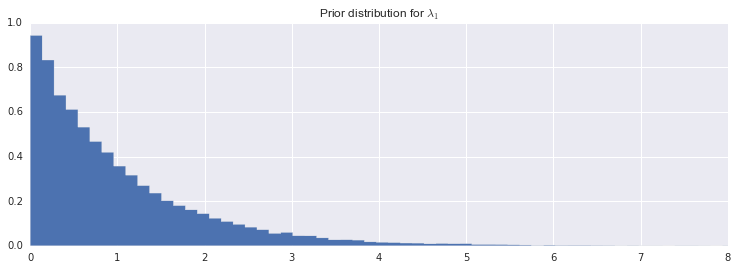

In [50]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
figsize(12.5, 4)

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=1, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlim(0, 8)

PyMC3中的随机变量有一个关键字`observed`，它有一个很简单的规则：固定变量的当前值为给定的数据，通常是一个Numpy数组或pandas DataFrame。比如：

In [51]:
data = np.array([10,5])
with model:
    fixed_variable = pm.Poisson('fxd', 1, observed=data)
print('value: ', fixed_variable.tag)

value:  scratchpad{'test_value': array([10,  5], dtype=int64)}


这就是我们如何将观测数据放入模型的方法：以固定值来初始化一个随机变量。

为了完成我们关于text message的例子，我们用观测数据集来固定PyMC3变量`observations`。

In [52]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson('obs', lambda_, observed=data)
print(obs.tag)

scratchpad{'test_value': array([10, 25, 15, 20, 35], dtype=int64)}


## Modeling approaches
开始贝叶斯建模的一个好的起始点是考虑你的数据是如何被生成的。将自己放在上帝视角，尝试想象你要重新创建该数据集。

这章剩下的部分我们要使用text message数据。从对使用的数据是如何生成的开始：

1. 我们从思考“什么是描述该count data最好的随机变量开始”。一个Poisson随机变量是一个好的候选项，因为它可以表示count data。
2. 下一步，我们想，“好啊，sms数据是服从poisson分布的，那为了得到这个分布我们还需要什么”。恩，poisson分布有一个参数$\lambda$。
3. 我们知道$\lambda$的值吗？不，实际上我们假设有两个$\lambda$，一个是为了生成早期的行为，另一个为了生成后面的行为。我们不知道什么时候行为会切换，所以又需要一个switchpoint $\tau$。
4. 这两个$\lambda$的分布应该是啥？几何分布就不错，因为它的变量取值范围在正实数区间。好吧，几何分布也有一个参数$\alpha$。
5. 那么$\alpha$可能是什么呢？我们不知道，在这一点上，我们可以继续为$\alpha$指定一个分布，但是更好的方法是停止这种行为，因为我们已经到达了一定程度的无知度：我们已经有了一个关于$\lambda$的先验假设(像是$\lambda$可能随着时间变化，它可能在10到30之间，等等）。我们实际上还没有任何对于$\alpha$的强先验假设，所以不要在随便对$\alpha$提出假设了。
    那怎么假设$\alpha$会好呢？我们认为$\lambda$在10-30之间，所以如果我们设置$\alpha$为很小的值（这样对应会在生成更大的值上有更大的概率）并没有反映出我们的全部先验假设。同样的，太大的$\alpha$值也丢失了我们关于先验的假设。让$\alpha$反映我们的belief的好的idea是设置$\alpha$的值，使得给出$\alpha$的前提下，$\lambda$的采样平均值等于我们观测数据的平均值。我们将在后面详细说明这个原理。
6. 我们对$\tau$何时发生并没有一个专家意见。所以我们会假设$\tau$来自于整个时间段的离散uniform分布。

下面我们给出图形化的模型图，箭头表明`parent-child`关系。 (provided by the [Daft Python library](http://daft-pgm.org/) )

<img src="http://i.imgur.com/7J30oCG.png" width = 700/>


PyMC3, and other probabilistic programming languages, have been designed to tell these data-generation *stories*. More generally, B. Cronin writes [5]:

> 概率式编程会解锁数据的叙述性解释， 它是业务分析的圣杯之一，也是科学解释的无名英雄。人们从故事的角度来思考——通过其无解释性来驱动决定的制定，可好可坏。但是这种方式不可能提供大规模的分析，取而代之，当人们的权衡自己的意见时，更加倾向于从数据中找出那些很偶然的因果解释。

> Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.



### Same story; different ending
通过模拟上面的步骤，我们可以再现出同样的数据集。

In [54]:
tau = np.random.randint(0, 80)
print(tau)

20


In [55]:
alpha = 1./ 20
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

4.54274534752 0.705150601092


In [56]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80-tau)]

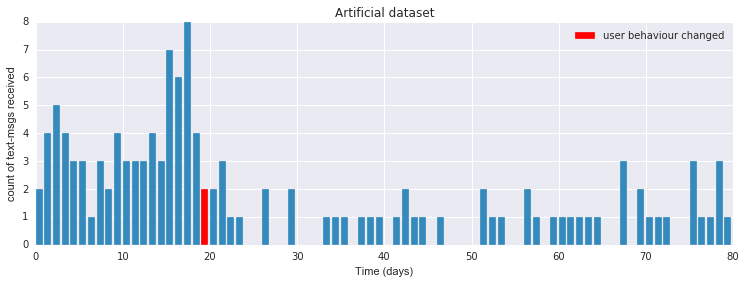

In [57]:
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

可以看到我们的人造数据跟观测数据不像：实际上这个概率可以很小。PyMC3旨在找到最小化这个概率的良好参数$\lambda_i$,$\tau$。

能生成新的人造数据是我们模型的一个附加功能，我们会看到这个功能对贝叶斯推理方法是很重要的。下面的代码可以不断生成新的数据，之后我们会看到如何用它们进行预测和测试我们模型性能。

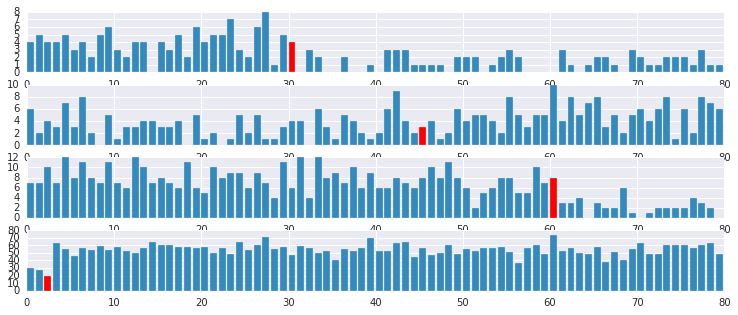

In [58]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

##### Example: Bayesian A/B testing
A/B测试时用于确定两种不同处理方式之间有效性差异的统计设计模式。例如，只要公司对药物A与药物B的有效性感兴趣。该公司将在其一部分试验中测试药物A，另一部分试验中测试药物B（该分数通常为1/2，但是我们将放松这个假设）。之后完成足够多的实验，内部统计人员分析数据，以确定那种药物能产生更好的结果。

类似的，前端web开发人员对其网站的哪种设计能产生更多销售额或者其他指标感兴趣。他们会将一部分访问者路由到站点A，另一部分路由到站点B，并记录是否访问者进行了消费。数据的记录是实时的，分析是之后进行的。

通常，后验实验分析使用被称为假设检验的方法来完成的，例如平均值差异测试或比例差异测试。这涉及到经常被误解的统计术语，比如Z-socre和p-values。你可以在统计课上学到这些术语（尽管没什么鸟用）。如果你和我一样，对这种分析方法不感冒，那么贝叶斯方法可以用更加自然的方法解决AB检测问题。

### A Simple Case
继续以web开发为例，目前我们只集中在分析站点A。假设存在用户被路由到站点A的概率为$0<p_A<1$，并且从站点A发生购买行为。这是网站A的真实有效性的衡量方式。目前，这个概率A对我们来说是未知的。

假设有N个人被路由到站点A，并且其中n个人在站点A买了东西。可以简单的总结出$P_A = \frac{n}{N}。不幸的是，观测频率$\frac{n}{N}$并不必然等于$P_A$，因为在对事件的发生的观测频率和真实频率之间存在差异。不幸的是，真是频率通常对我们来讲是隐藏起来的，必须通过观测数据来*推断*真实频率。

对我们的A/B测试例子，我们使用我们知道的东西，N（总的实验次数）和n（总的转化次数），然后估计$P_A$，也许它就是真实的购买频率。

为了构建一个Bayesian model，我们需要为我们未知的quantities指定先验分布。首先，让我们假设$P_A$是uniform over [0,1]：

In [59]:
import pymc3 as pm

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

如果我们有更强的beliefs，我们可以在prior里表达。比如这里，假设$P_A = 0.05$,$N=1500$，然后我们模拟是否每个用户发生购买行为。为了模拟这N次试验，我们将用一个Bernoulli分布: 如果$X \sim Ber(p)$，那么$X$有$p$的概率等于1，$1-p$的概率等于0.当然，实际中，我们不知道$P_A$是多少，这里只是为了模拟数据。

In [60]:
# set constant
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ..., 0 0 0]
77


这次试验中观测到的频率是：

In [61]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0513
Does this equal the true frequency? False


我们将生成的观测数据赋值给PyMC3模型对象中的`observed`变量，然后运行我们的推断算法：

In [62]:
# Include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli('obs', p, observed=occurrences)
    # To be explained in charpter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18500/18500 [04:07<00:00, 75.23it/s]


现在画出未知$P_A$的后验分布：

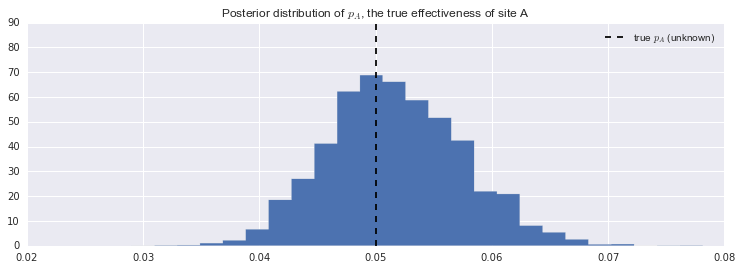

In [63]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

这个后验分布衡量了对于给定的观测数据下，$P_A$的不确定性。

### A and B Together
同样的方法可以分析站点B。但是我们真正关心的是$P_A$和$P_B$之间的差异。让我们推断$P_A$和$P_B$，$delta = P_A - P_B$，一次搞定。我们可以通过PyMC3的确定型变量完成这个工作。（我们假设$P_B=0.04$，所以$delta = 0.01$，$N_B=750$（明显比$N_A$要少很多），之后可以像站点A那样生成站点B的观测数据）。

In [64]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [65]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.0486666666667
0.0333333333333


In [66]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20500/20500 [07:03<00:00, 48.43it/s]


下面我们画出这三个未知变量的后验分布图：

In [67]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

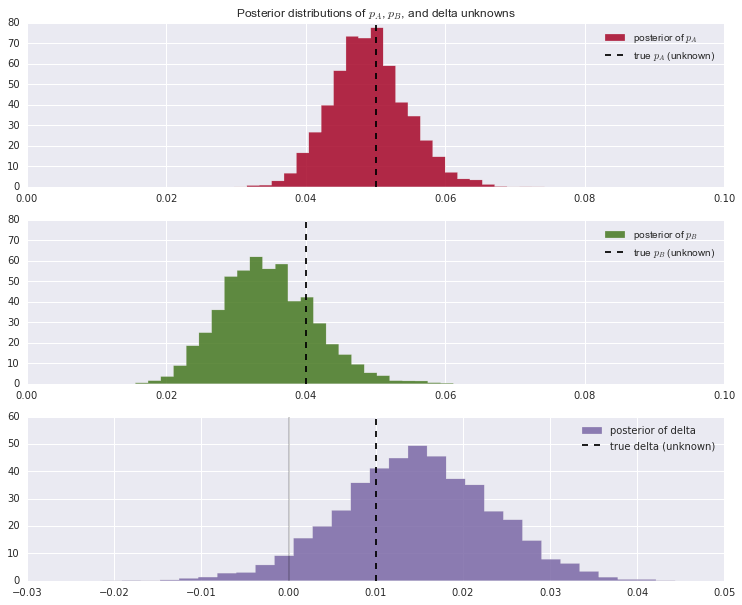

In [68]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

注意到因为$N_B < N_A$，我们关于$P_B$的后验分布要比$P_A$宽，这暗示着我们对$P_B$的确定程度低于$P_A$。

从delta的后验分布中，我们看到主要的概率密度大于$delta=0$，这暗示着站点A比站点B的效果要好些。

In [69]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.047
Probability site A is BETTER than site B: 0.953


如果这个概率过高，使得做决策变的过于容易，我们可以在站点B增加更多的测试（因为站点B的观测数据少，每次增加观测数据都会比增加站点A的观测数据更具推断力）。

尝试加入参数`true_p_A, true_p_B, N_A, N_B`，看看delta的后验分布会变成什么样子。注意到，所有的这些实验，站点A和站点B观测数据的不同都没有被提及：这种情况很自然的对应到贝叶斯分析。

我希望读者对这种风格的A/B测试直觉上比频率派的假设检验方法感觉更加自然合理。之后我们将看关于这个模型的两个扩展：第一个似乎帮助动态地调整那个不好的站点，第二个是通过将分析减少到单个方程，从而改善计算的速度。

## An algorithm for human deceit
社会数据有个额外有趣的地方，那就是人们并不总是诚实地做出回应，这进一步增加了推理的复杂性。所以可以肯定地说，真正的比率少于所观察到的比率。

通过提出一个优雅的解决方案来规避这种不诚实问题，并且为了展示贝叶斯建模，我们首先要引入binomial分布。

### The Binomial Distribution
The mass distribution looks like:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

如果$X$是个binomial随机变量with参数$p$和$N$。表示为$X \sim \text{Bin}(N,p)$，那么$X$表示在N次试验中事件发生的次数。下面我们画出其概率质量分布。

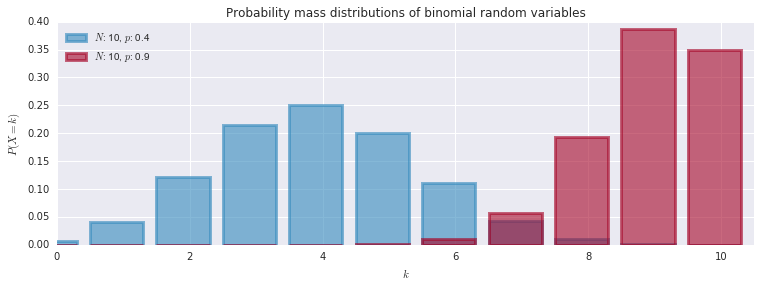

In [70]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

特别地，当$N=1$时，就是Bernoulli分布了。关于这两个分布的随机变量之间，还有其他的联系。如果我们有$X_1,X_2,\dots,X_N$个Bernoulli随机变量with相同的$p$，那么有$Z=X_1+X_2+\dots+X_N \sim \text{Binomial}(N,p)$。

##### Example: Cheating among students
我们将使用binomial分布来确定在考试期间学生作弊的频率。N等于全部参加考试的学生，并假设每个学生在考试后接受采访（不用承担后果），我们得到整数$X$“是的，我作弊了”这样的答案。我们就可以得到关于$p$的后验概率分布。

这个模型完全没有道理。没有学生，甚至在作弊没有任何惩罚的情况下，会承认作弊。我们需要一个更好的*算法*来回答是否作弊。理想情况下，算法应该鼓励个体在保留其隐私的前提下诚实回答。下面提出的算法我个人非常欣赏其独创性和有效性：
> 在对每个学生进行采访前，学生抛一个硬币，且不让对方知道结果。如果硬币的头朝上，那么学生要同意诚实回答问题。否则，学生将会偷偷再次抛硬币，如果硬币的头朝上，那么回答“是的，我作弊了”，如果尾朝上，回答“不，我没有作弊”。这样，采访者就不知道“Yes”是因为学生承认作弊，还是因为再第二次抛硬币时头朝上。这样受访者的隐私得到了保障，研究者就可以获得诚实的回答。

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers. 

我称这个为隐私算法。当然可以认为采访者还是会收到虚假的回答，因为"yes"回答不是承认作弊，而是由随机抛出的头朝上的硬币得到的结果。另外一种观点是研究人员将会丢弃大约一半的原始数据集，因为一半的回答会是噪音。但是他们已经获得了一个系统性的数据生成过程。而且，他们不需要纳入虚假回答的可能性。我们可以使用PyMC3挖掘这个noisy模型，并且找到一个说谎者真实频率的后验分布。

现有100个学生被发现作弊，我们希望找出作弊者的概率$p$。PyMC3有好几个方法来完成这个任务，我会展示最有说服力的，然后展示最简单的版本。两个版本都得到相同的推论，在我们的数据生成模型中，我们从先验分布中采样真实的作弊者概率$p$。因为我们对$p$一无所知，我们将指定先验为$\text{Uniform}(0,1)$。

In [71]:
import pymc3 as pm

N = 100
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)

我们对100个学生指定其为Bernoulli随机变量：1表示其作弊了，0表示未作弊。

In [72]:
with model:
    true_answers = pm.Bernoulli('truths', p, shape=N, testval=np.random.binomial(1, 0.5, N))

如果我们运行这个算法，那么下一步就是每个学生第一次抛硬币的结果。这个过程依旧可以通过对100个Bernoulli随机变量采样来模拟，其中$p=\frac{1}{2}$：1表示头，0表示尾。

In [73]:
with model:
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag)

scratchpad{'test_value': array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0], dtype=int64)}


尽管不是每个人都抛两次硬币，我们依然可以对每个人抛第二次硬币建模。

In [74]:
with model:
    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

用上面这些变量，我们可以返回一个可能真实的对“yes”回答的观测概率。我们用确定型变量来表达这个结果：

In [75]:
import theano.tensor as tt
with model:
    val = first_coin_flips * true_answers + (1 - first_coin_flips) * second_coin_flips
    observed_proportion = pm.Deterministic('observed_proportion', tt.sum(val) / float(N))

代码`fc*t_a + (1-fc)*sc`是隐私保护算法的核心。Elements in this array are 1 if and only if i) the first toss is heads and the student cheated or ii) the first toss is tails, and the second is heads, and are 0 else. Finally, the last line sums this vector and divides by float(N), produces a proportion.

In [79]:
observed_proportion.tag.test_value

array(0.51)

接下来，我们需要一个数据集。在完成抛硬币过程之后，研究者收到35个“yes”回答。To put this into a relative perspective, if there truly were no cheaters, we should expect to see on average 1/4 of all responses being a "Yes" (half chance of having first coin land Tails, and another half chance of having second coin land Heads), so about 25 responses in a cheat-free world. On the other hand, if all students cheated, we should expected to see approximately 3/4 of all responses be "Yes".

研究者观察Binomial随机变量，N=100，p=observed_proportion，value=35.

In [80]:
X = 35

with model:
    observations = pm.Binomial('obs', N, observed_proportion, observed=X)

下面，我们将所有相关的变量放入一个`Model`容器，然后运行我们的这个黑盒算法。

In [81]:
# To be explained in Chapter 3!
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40500/40500 [24:24:33<00:00,  2.14s/it]


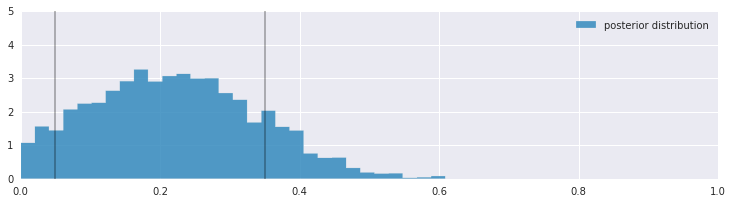

In [82]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

关于上面的图，我们还是相当不确定真实的作弊者频率，但是我们将其缩小到范围0.05到0.35之间（用实线画出）。这个结果相当好，作为一个*prior*，我们不知道有多少学生做过弊（因为先验分布是uniform）。另一方面，这个结果因为高概率后验的范围有3个window这么宽。我们还获得了其他有用结论吗？还是说我们依旧对真实作弊频率一无所知？

我会辩解，我们确实是还发现了一些东西。根据我们的后验，没有作弊者是不可信的。即作弊后验概率为$p=0$的概率很低。

这种算法可以用于从用户那里收集有关隐私的信息，并且*有理由*相信得到的数据是可靠的，尽管有噪音数据存在，但是胜在真实。

### Alternative PyMC3 Model
给定一个作弊概率p的概率值（我们从上帝视角得知），我们可以推出学生回答yes的概率：
\begin{align}
P(\text{"Yes"}) = & P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\\\
& = \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}

因此，只要知道p就等于知道学生回答“yes”的概率。在PyMC3里，给定p值，我们可以写出一个确定性函数来评估回答是“yes”的概率。

In [85]:
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)
    p_skewed = pm.Deterministic('p_skewed', 0.5*p + 0.25)

我也可以用`p_skewed = 0.5*p + 0.25`来代替，元素加法和乘法会隐式的创建一个`deterministic1`变量，但是为了清楚起见，我想明确确定性变量的模板。

如果我们知道回答“yes”的概率，即`p_skewed`，并且我们有N=100个学生，那么每个学生回答“yes”的概率分布为binomial分布with参数$N$和$p_skewed$。

下面我们假设有观察到35个回答“yes”的人，有下面的代码：

In [86]:
with model:
    yes_responses = pm.Binomial('number_cheaters', 100, p_skewed, observed=35)

下面我们将所有相关的变量放入`Model`容器，然后运行这个算法。

In [87]:
with model:
    # To be explained in chapter 3!
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25500/25500 [00:13<00:00, 1825.86it/s]


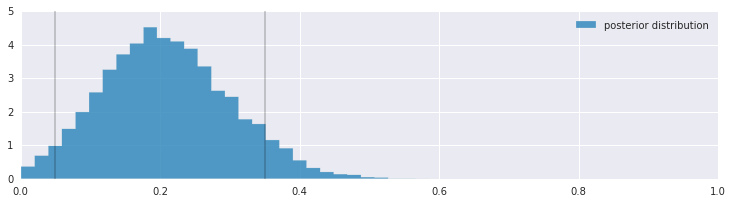

In [88]:
figsize(12.5, 3)
p_trace = burned_trace['freq_cheating']
plt.hist(p_trace, histtype='stepfilled', normed=True, alpha=0.85, bins=30, label='posterior distribution', color='#348ABD')
plt.vlines([.05, 0.35], [0, 0], [5,5], alpha=0.2)
plt.xlim(0, 1)
plt.legend()

## More PyMC3 Tricks

### protip: Arrays of PyMC3 variables
没有理由我们不能在Numpy数组中存储多个异构的PyMC3变量。只需要记住初始化数组时设置数组的`dtype`为`object`即可。比如：

In [90]:
N = 10
X = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        X[i] = pm.Exponential('x_%i' % i, (i+1)**2)

本章余下的部分是一些关于PyMC3建模的练习和例子：

##### Example: Challenger Space Shuttle Disaster <span id='challenger'/>

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):

Temp (F), 0-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


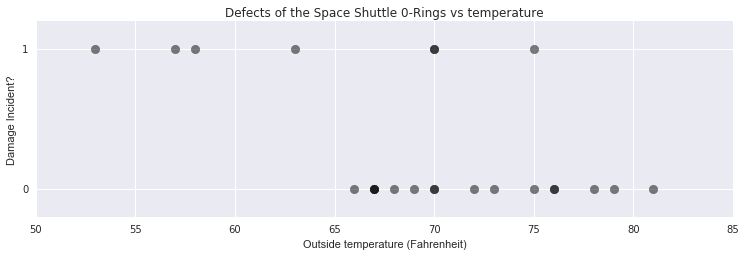

In [92]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt('data/challenger_data.csv', skip_header=1,
                               usecols=[1, 2], missing_values='NA',
                               delimiter=',')
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of tempature (the first column)
print('Temp (F), 0-Ring failure?')
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color='k', alpha=0.5)
plt.yticks([0, 1])
plt.ylabel('Damage Incident?')
plt.xlabel('Outside temperature (Fahrenheit)')
plt.title('Defects of the Space Shuttle 0-Rings vs temperature')

很明显，随着外部温度越来越低，发生损坏事故的概率越来越大。我们对这个感兴趣是因为在温度和事故发生之间看上去似乎没有一个严格的截止点。所以我们的提问方式为“在温度为$t$时，发生损坏事故的概率是多少？”这个例子目标就是要回答这个问题。

我们需要一个关于温度的函数，称它为$p(t)$。这个函数的取值范围从0到1（为了对概率建模）,随着温度的增加，其函数结果从1到0。有很多函数可以达到这个要求，但是最popular的选择是*logistic function*。
$$p(t) = \frac{1}{1+e^{\;\beta t}}$$

在这个函数中，$\beta$就是我们所未知的变量，下面画出$\beta=1,3,-5$时的函数图像。

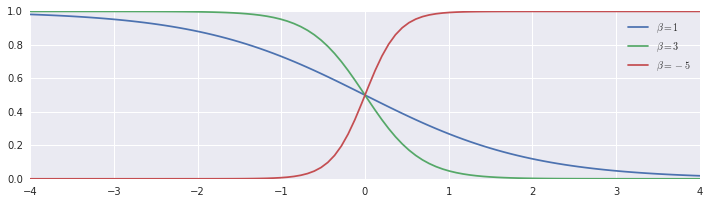

In [97]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend()

这个函数还缺点东西，这里的函数取值范围以0为中心，但是我们上面的数据取值范围是从65到70.我们需要增加一个*bias*项到我们的函数中：

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

下面我们画出这个函数图像。

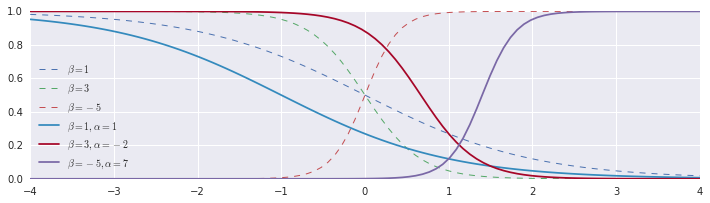

In [98]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

### Normal distributions
一个正太分布随机变量，写作$X \sim N(\mu, 1/\tau)$，它有两个参数:均值$mu$和精度$\tau$。熟悉正太分布的人也许会用$\sigma^2$替换$tau^{-1}$，实际上这两个写法是互惠的。这种写法上的改变目的是简化数学分析并且也是旧式贝叶斯方法的产物。只需要记住：$\tau$变小，导致更宽的概率分布（就是增加了不确定性）。无论如何，$tau$都是正数。

$N(\mu, 1/\tau)$的概率密度函数可以写作：
$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right) $$

我们下面画出其不同参数下的概率密度图。

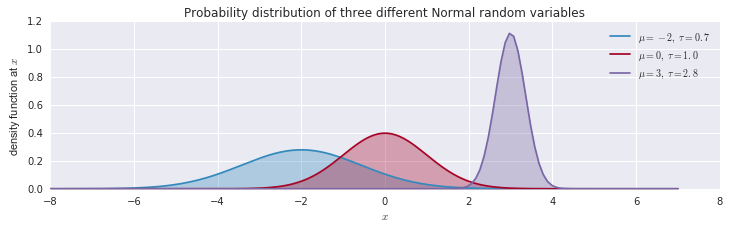

In [99]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

正太随机变量可以是任何实数，但是其值总是会以$\mu$为中心。实际上，正太随机变量的期望值等于其$\mu$：

$$ E[ X | \mu, \tau] = \mu$$

并且，它的方差等于其精度$\tau$的倒数：

$$Var( X | \mu, \tau ) = \frac{1}{\tau}$$

下面我们继续对我们的挑战者号航天飞船进行建模：

In [101]:
import pymc3 as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not

# notice the `value` here, We explain why below:
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, tau=0.001, testval=0)
    alpha = pm.Normal('alpha', mu=0, tau=0.001, testval=0)
    p = pm.Deterministic('p', 1.0 / (1. + tt.exp(beta*temperature + alpha)))

我们产生了概率p的值，但是我们如何与观测数据关联？一个Bernoulli随机变量with参数$p$，写作$\text{Ber}(p)$，表示一个随机变量取值为1的概率为$p$。因此，我们的模型表示为：

$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

其中$p(t)$表示我们的logistic函数，$t_i$则是我们观测到的温度。注意到前面的代码里，我们将`beta`和`alpha`的值设为0。这么做的原因是如果`beta`和`alpha`值太大的话，会导致`p`等于1或者0。不幸的是，`pm.Bernoulli`实际上不会有概率为0或1这样极端的参数，尽管在数学上这样的参数值是有定义的。所以，通过设定`beta`和`alpha`的起始值为0，我们得到的变量`p`会是个合理的起始值。这不会影响我们的结果，也不意味着我们在先验分布中增加了额外的信息。这仅仅是在PyMC3中计算的警告。

In [102]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli('bernoulli_obs', p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

Optimization terminated successfully.
         Current function value: 19.010705
         Iterations: 11
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120500/120500 [17:54<00:00, 112.13it/s]


我们在观测数据中训练了我们的模型，现在我们可以从后验概率分布中采样了。首先看看关于$\alpha$和$\beta$的后验分布。

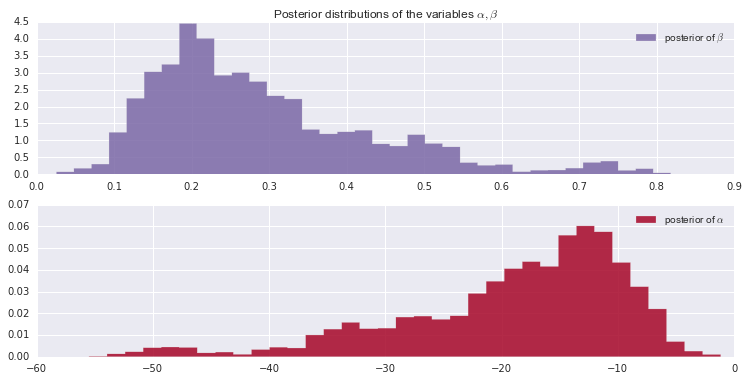

In [103]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

$\beta$的所有采样值都大于0。如果其后验分布是围着0，那么我们也许可以假设$\beta=0$，暗示着温度对出事故的概率没有影响。

同样的，所有$\alpha$的后验值都是负值，且远离0，暗示着相信$\alpha$很明显小于0这个假设是正确的。

考虑到数据的散布，我们对真实的参数值非常的不确定（尽管考虑到低样本量和出事故和没出事故的样本重叠问题，这个情况或许是可以预见的）。

下面，让我们看看在指定好温度值的前提下，出事故的*期望的概率*。也就是说，我们要从后验分布中取出所有采样值，并且平均它们，然后得到$p(t_i)$的可能值。

In [104]:
t = np.linspace(temperature.min()- 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

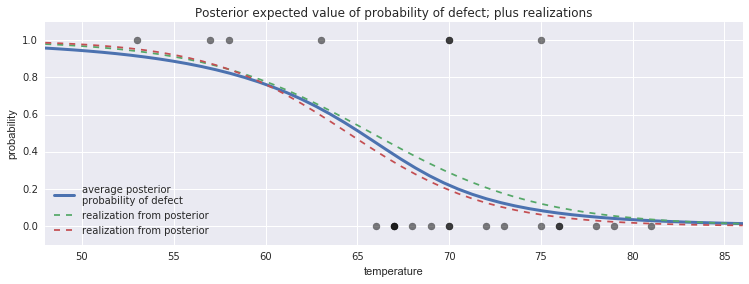

In [105]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

上面我们还绘制了两个可能的实际关联。当然也可以画成其他的图。蓝色的线是当我们平均所有20000个可能的虚线后画出的结果。

一个有趣的问题是：当什么温度的情况下，我们对发生事故的概率的确定程度最低？下面我们对每个温度值，画出其出事故的期望值的线及其95%的置信区间。

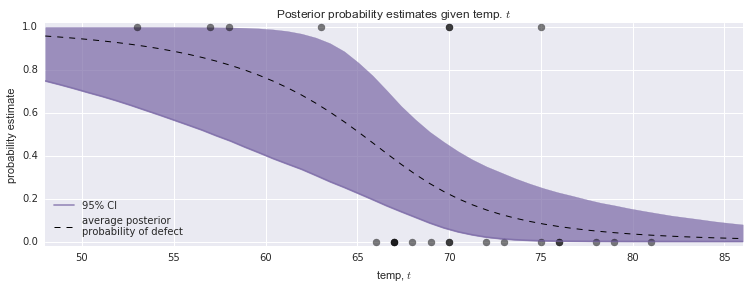

In [106]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

观察图，比如说在65度时，我们有95%的相信发生事故的概率在0.25到0.75之间。

更一般地，我们可以看到温度在60度附近时，置信区间CI蔓延到[0,1]的速度突然变快。当我们到了70度时，置信区间又变得紧致了。这可以给我们一些接下来如何做的启示：我们应该测试更多在60-65度的O型圈O-rings，以便更好地估计该范围内的概率。同样的，当向科学家汇报你的估计时，你应该非常的小心地简单地告诉他们预期的概率，因为我们可以看出这并不能反映后验分布的*wide*。

### What about the day of the Challenger disaster?
在挑战者号出事那天，飞船外面的温度是华氏31度。那么这时发生事故的后验分布概率值是多少?根据下面的图，几乎可以肯定挑战者号会遭遇到O型圈出现缺陷。

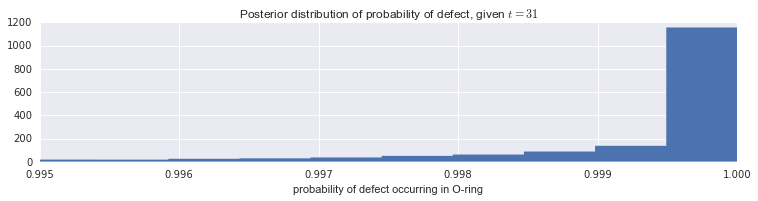

In [107]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

### Is our model appropriate?
持怀疑态度的读者会说“你故意选择了温度和事故之间关联的函数为logistic函数$p(t)$，以及特定的先验分布（正太分布），也许其他函数或者先验分布会得出不同的结果。我如何知道自己的选择是好的？”这样问很对。考虑一个额外的解决方案，如果我让函数$p(t)=1,\; \forall t$，那么什么才能保证事故一定发生：很明显，这个模型很烂，无法预测那天发生事故的概率。另一方面，如果我依旧选择$p(t)$是逻辑回归，但是指定所有的先验值都必须在0附近，这么做很可能我们会有一个非常不同的后验分布。我们如何知道这模型可以表达数据？这些动机都鼓励我们要去度量模型的拟合程度。

我们可以思考：*如何测试我们的模型是好是坏？*一个想法是去比较观测数据和模型生成的人造数据。这其中的关系是：如果人造数据和观测数据不相似，从统计上说，很大可能，我们的的模型不能准确表达观测数据。

在这一章早些部分，我们生成了关于SMS短信的人造数据。我们通过从先验分布中采样。我们看到了生成的数据是多么的不同，很少部分看起来像是观测数据。在这个例子中，我们应该从*后验分布*中采样，从而生成合理的人造数据。幸运的是，我们的贝叶斯框架是这个想法很容易实现。我们只需要create一个新的`Stochastic`变量，这个随机变量跟我们存储的观测变量完全一样，只是不包括观测数据。如果你回忆下，我们存储观测数据的`Stochastic`变量的代码是：

    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)

Hence we create:
    
    simulated_data = pm.Bernoulli("simulation_data", p)

Let's simulate 10 000:

In [108]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10500/10500 [09:31<00:00, 16.73it/s]


(10000, 23)


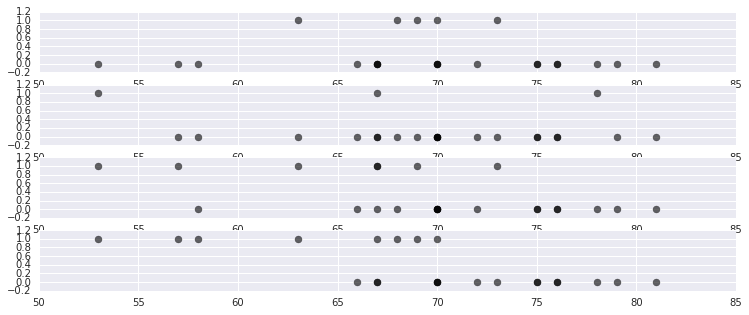

In [109]:
figsize(12.5, 5)

simulations = trace["bernoulli_sim"]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)

注意到上面的图是不同的。

我们希望评估我们的模型到底有多好。“好”是一个主管的术语，所以结果必须是相对于其他模型的。

我们也会以图形的方式做这个，这似乎是一个更不客观的方法。替代方案是使用*贝叶斯 p-values*。这些仍然是主观的，因为好与坏之间的适当切换点是任意的。Gelman强调[7]，图形测试比p-values更加明显。我们同意他的说法。

下面的图形测试对逻辑回归来讲是一个新颖的数据可视化方法。这些图被称为*separation plots*[8]。对一套我们需要对比的模型，每个模型都画在各自的画布区域。我省略了大多数关于separation plots的技术细节 [original paper](http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf)，但是会总结一下如何使用。

对每个模型来讲，对一个特定的温度，我们计算其后验分布预测为1值的次数对应的概率，也就是通过平均值的计算，得到$P(|text{Defect} = 1 | \tau,\alpha,\beta)$。这给出了在我们数据集中每个事故发生的后验概率。比如说，对于上面我们使用的模型：

In [110]:
posterior_probability = simulations.mean(axis=0)
print('posterior prob of defect | realized defect')
for i in range(len(D)):
    print('%.2f                       |        %d'  % (posterior_probability[i], D[i]))

posterior prob of defect | realized defect
0.44                       |        0
0.22                       |        1
0.27                       |        0
0.32                       |        0
0.38                       |        0
0.15                       |        0
0.13                       |        0
0.22                       |        0
0.83                       |        1
0.62                       |        1
0.22                       |        1
0.06                       |        0
0.38                       |        0
0.89                       |        1
0.38                       |        0
0.09                       |        0
0.22                       |        0
0.04                       |        0
0.08                       |        0
0.05                       |        0
0.10                       |        1
0.08                       |        0
0.81                       |        1


接下来，我们通过后验概率来排序：

In [111]:
ix = np.argsort(posterior_probability)
print('probb | defect')
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

probb | defect
0.04  |   0
0.05  |   0
0.06  |   0
0.08  |   0
0.08  |   0
0.09  |   0
0.10  |   1
0.13  |   0
0.15  |   0
0.22  |   0
0.22  |   0
0.22  |   1
0.22  |   1
0.27  |   0
0.32  |   0
0.38  |   0
0.38  |   0
0.38  |   0
0.44  |   0
0.62  |   1
0.81  |   1
0.83  |   1
0.89  |   1


我们把上面的结果打包到`separation_plot`函数中。

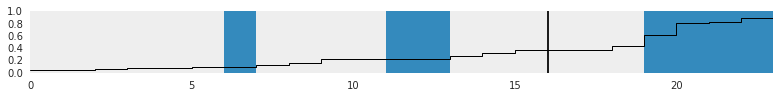

In [112]:
from separation_plot import separation_plot


figsize(11., 1.5)
separation_plot(posterior_probability, D)

蛇形线是排序的概率，蓝条表示事故发生，空格（或者说灰条）表示没发生事故。随着概率的上升，我们看到越来越多的事故发生。在右侧，表明随着后验概率越来越大（接近了1），更多的事故会发生。这是个好的结果，理想情况下，所有的蓝色条都应该靠近右边，并且偏离这些预测错误的地方。

黑色的垂直线表示在给定的模型下，观测到的期望的事故发生次数。这允许用户看到模型预测的事故总数如何与观测数据中的实际事故总数进行比较。

将其与其他模型的分离图进行比较会有更多信息出现。
1. 完美的模型，是指如果发生了事故，那么预测的后验概率等于1.
2. 一个完全随机的模型，是指无论温度如何，都给出预测的随机概率。
3. 一个常数模型：其中$P(D=1 \;|\; t) = c, \forall t$。$c$的最佳选择是观测到的事故频率，这里是 7/23。

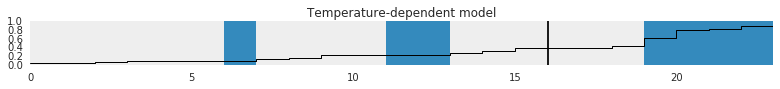

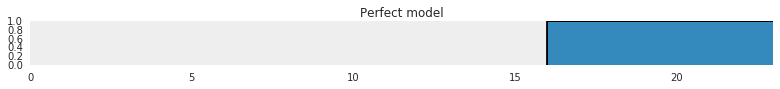

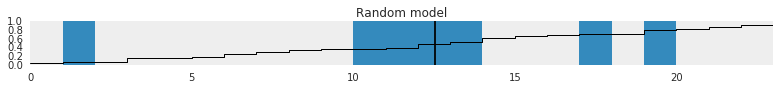

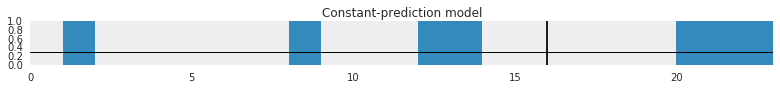

In [113]:
figsize(11., 1.25)

# Our temperature-dependent model
separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
p = D
separation_plot(p, D)
plt.title("Perfect model")

# random predictions
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

# constant model
constant_prob = 7./23*np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");

在随机模型中，我们看到随着概率的增加，右侧不存在事故发生的堆积。常数模型也是这样。

在完美模型中，概率线没有很好的展示，因为它被卡在图的底部和顶部。当然，完美模型只是为了示范，我们不能从它推断出任何科学性的推论。

##### Exercises
1\. Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmative responses? 10? 50? 

2\. Try plotting $\alpha$ samples versus $\beta$ samples.  Why might the resulting plot look like this?

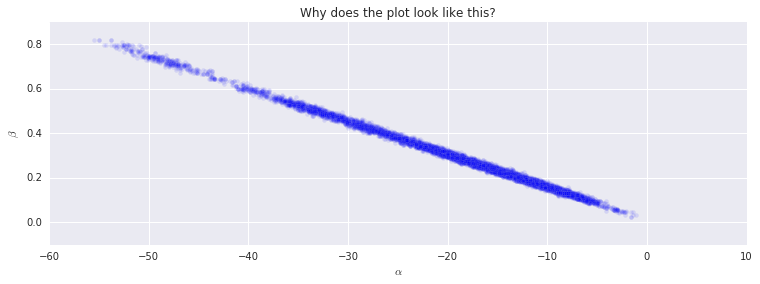

In [114]:
#type your code here.
figsize(12.5, 4)

plt.scatter(alpha_samples, beta_samples, alpha=0.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");

### References

-  [1] Dalal, Fowlkes and Hoadley (1989),JASA, 84, 945-957.
-  [2] German Rodriguez. Datasets. In WWS509. Retrieved 30/01/2013, from <http://data.princeton.edu/wws509/datasets/#smoking>.
-  [3] McLeish, Don, and Cyntha Struthers. STATISTICS 450/850 Estimation and Hypothesis Testing. Winter 2012. Waterloo, Ontario: 2012. Print.
-  [4] Fonnesbeck, Christopher. "Building Models." PyMC-Devs. N.p., n.d. Web. 26 Feb 2013. <http://pymc-devs.github.com/pymc/modelbuilding.html>.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.
- [6] S.P. Brooks, E.A. Catchpole, and B.J.T. Morgan. Bayesian animal survival estimation. Statistical Science, 15: 357–376, 2000
- [7] Gelman, Andrew. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 2 Apr. 2013.
- [8] Greenhill, Brian, Michael D. Ward, and Audrey Sacks. "The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models." American Journal of Political Science. 55.No.4 (2011): n. page. Web. 2 Apr. 2013.

In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()